# Exploration 9
# 미니프로젝트: 폐렴아 기다려라!
# Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

In [3]:
# data load
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 정상 이미지와 폐렴 이미지의 구분은 파일 경로로 할 수 있음
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있음
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있음
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
#tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있음
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train, val dataset 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

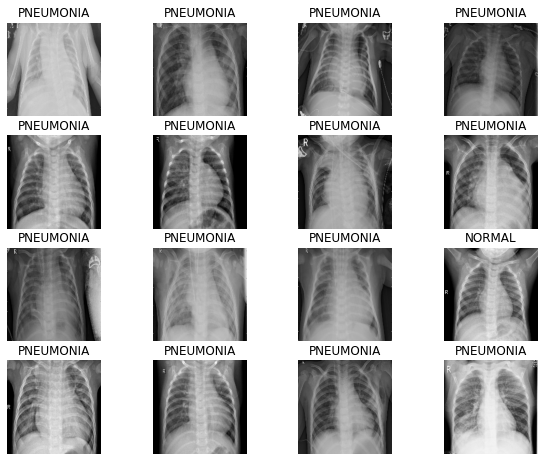

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여준다
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- Dense Block은 아래와 같이 만듭니다.

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 63s 191ms/step - loss: 0.4011 - accuracy: 0.7962 - precision: 0.9505 - recall: 0.7659 - val_loss: 0.7471 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2478 - accuracy: 0.9054 - precision: 0.9721 - recall: 0.8986 - val_loss: 1.6213 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2026 - accuracy: 0.9219 - precision: 0.9773 - recall: 0.9162 - val_loss: 0.6781 - val_accuracy: 0.7740 - val_precision: 0.7648 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1914 - accuracy: 0.9284 - precision: 0.9740 - recall: 0.9285 - val_loss: 0.0688 - val_accuracy: 0.9740 - val_precision: 0.9868 - val_recall: 0.9778
Epoch 5/25
261/261 [==============================] - 52s 198ms/step - loss: 0.1669 - accura

# Step 7. 결과 확인과 시각화

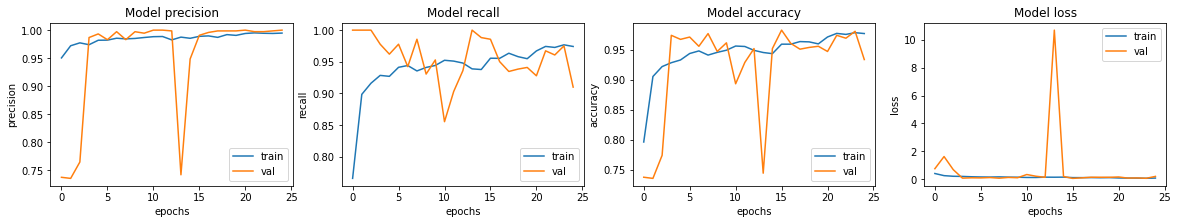

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 0.5765 - accuracy: 0.8894 - precision: 0.8759 - recall: 0.9590
Loss: 0.5764666795730591,
Accuracy: 0.8894230723381042,
Precision: 0.8758782148361206,
Recall: 0.9589743614196777


# 🤔 또 다른 시도
- 사실 위의 코드로도 Accuracy가 85% 이상을 달성해서 따로 다른 방법을 써서 Accuracy를 더 올릴 필요는 없지만 그래도 다른 방법을 더 찾아봄

# 1️⃣ 첫번째 방법
- BATCH_SIZE를 초기의 2배값인 64로 증가해봄 -> Accuracy 84%까지 올라옴
- But BATCH_SIZE를 초기의 4배값인 128로 증가했더니 오히려 더 떨어짐

# 2️⃣ 두번째 방법
- BATCH_SIZE는 초기 사이즈와 동일하게 준 후, EPOCHS 횟수를 절반으로 줄여봄 -> Accuracy 84%까지 올라옴
- 두번째 방법을 한번더 시도하니까 Accuracy 87%까지 올라옴

# 3️⃣ 세번째 방법
- shuffle_buffer_size를 조절하는 방법인데요
- shuffle_buffer_size는 더 줄이지도 말고 딱 1000으로 맞춘다!! -> Accuracy 77% 정도 나옴
- 세번째 방법을 한번 더 시도하니까 Accuracy가 88%까지 올라감!!

# 4️⃣ 네번째 방법
- ImageDataGenerator 클래스를 사용해서 데이터 세트를 생성하면 이미지 데이터 학습을 쉽게 할 수 있다.
- CNN 모델을 설계해준다(*CNN을 사용하려면 tensorflow는 2.20와 keras는 2.3.1 버전을 다운그레이 해주어야 한다)
- 그랬더니 Accuracy가 90% 달성함!!

# 회고
- X-Ray 자료를 통해서 특이점을 찾아내어서 질병 유무를 체크할 수 있는 점이 흥미로웠다. 
- 이번에는 Accuracy가 너무 빨리 85%이상을 달성해서 다른 방법들을 찾아볼 수 있는 시간이 있었다 ㅎㅎ
- 다른 방법들을 찾아보면서 이런 저런 방법을 통해서도 더 낮아지고 더 높아질 수 있다는 것을 알았다.
- 그리고 폐렴도 유방암 분류처럼 폐렴을 폐렴이 아니라고 판단하면 안되기 때문에 recall이 중요하지 않을까 한다.